In [1]:
# Imports
import numpy as np
import math
import time
import json
import pandas as pd
import requests
from pandas import json_normalize
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mplsoccer.pitch import Pitch
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from sklearn.cluster import KMeans
pd.options.mode.chained_assignment = None
barca_burgundy = '#A50044'
barca_gold = '#EDBB00'
barca_blue = '#004D98'
usual_blue = '#5499C7'
usual_red = '#ba4f45'
from matplotlib import rcParams
rcParams['text.color'] = '#c7d5cc'
rcParams["figure.facecolor"] = "#22312b"

In [2]:
def read_df(i):
    df = pd.read_csv("Season"+str(i)+".csv",encoding = 'utf-8-sig',low_memory=False)
    return df

In [3]:
seasonlist = ['08-09','09-10','10-11','11-12','12-13','13-14','14-15','15-16','16-17','17-18','18-19']

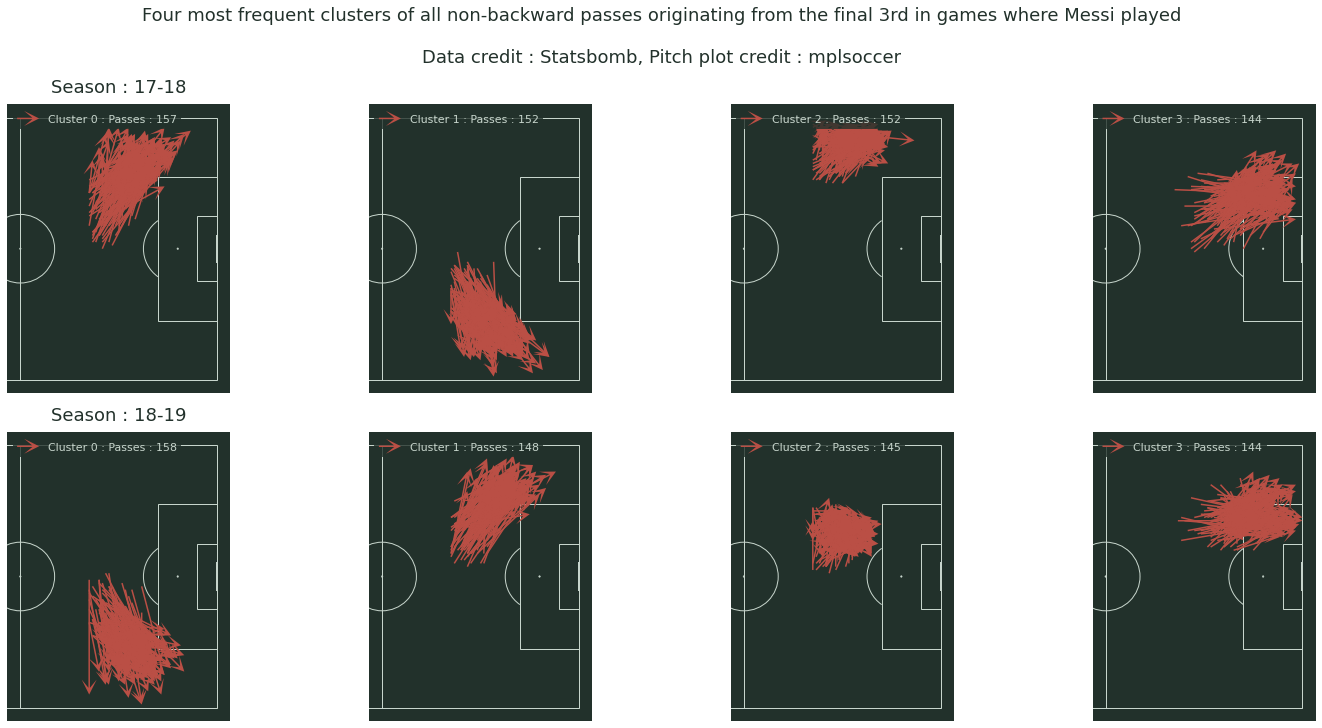

In [7]:
# Read dataframe
def clustercalc(season):
    df = read_df(season)
    passes = df.query("(type_name=='Pass')&(team_name=='Barcelona')\
                    &(pass_type_name not in ['Free Kick', 'Corner', 'Throw-in', 'Kick Off'])\
                    &(pass_outcome_name not in ['Incomplete', 'Out', 'Unknown', 'Pass Offside','Injury Clearance'])")
    passes['location'] = passes['location'].astype(str).str.strip('[]')
    passes['x_loc'] = passes['location'].str.split(', ').str.get(0).str.strip().astype(float)
    passes['y_loc'] = passes['location'].str.split(', ').str.get(1).str.strip().astype(float)
    passes['pass_end_location'] = passes['pass_end_location'].astype(str).str.strip('[]')
    passes['end_x_loc'] = passes['pass_end_location'].str.split(', ').str.get(0).str.strip().astype(float)
    passes['end_y_loc'] = passes['pass_end_location'].str.split(', ').str.get(1).str.strip().astype(float)
    passes = passes[(passes['x_loc']>80)&(passes['end_x_loc']>=passes['x_loc'])]
    nc = 21
    km = KMeans(n_clusters=nc, init='random', random_state=0)
    y_km = km.fit_predict(passes[['x_loc','y_loc','end_x_loc','end_y_loc']])
    passes['Cluster'] = y_km
    passlist = [len(passes[passes.Cluster==i]) for i in range(nc)]
    passlist = np.asarray(passlist)
    ranked = np.argsort(passlist)
    largest_indices = ranked[::-1][:4]
    return passes, largest_indices 
season_start = 9
season_end = 11
no_of_seasons = season_end - season_start
plt.style.use('ggplot')
pitch = Pitch(pitch_type='statsbomb', orientation='horizontal', figsize = (20,5*no_of_seasons),
                  pitch_color='#22312b', line_color='#c7d5cc', linewidth=1,view='half',layout=(no_of_seasons, 4),
                  constrained_layout=True, tight_layout=False)
fig, ax = pitch.draw()
fig.suptitle("Four most frequent clusters of all non-backward passes originating from the final 3rd "+ 
             "in games where Messi played" + '\n' + '\n' +
            "Data credit : Statsbomb, Pitch plot credit : mplsoccer",fontsize=18, color="#22312b")
for season in range(season_start,season_end):
    passes, indexlist = clustercalc(season)
    for j in range(4):
        passcluster = passes[passes['Cluster']==indexlist[j]]
        pitch.arrows(passcluster["x_loc"], passcluster["y_loc"],
                     passcluster["end_x_loc"], passcluster["end_y_loc"], width=1.5,
                     headwidth=10, headlength=10, color=usual_red, ax=ax[season-season_start,j], 
                     label='Cluster '+str(j)+' : Passes : '+str(len(passcluster)))
        ax[season-season_start,j].legend(facecolor='#22312b', handlelength=2, edgecolor='None', fontsize=11, loc='upper left')
        ax[season-season_start,0].set_title('Season : '+seasonlist[season],fontsize=18, pad=12,color="#22312b")
# fig.savefig("EVcluster")